<a href="https://colab.research.google.com/github/annvorosh/GB/blob/StatMed/StatMed_L04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Курсив*
# Урок 4. Тесты для трех и более групп сравнения, post-hoc тестирование

Поработаем с таблицами, для которых на предыдущем занятии вы изучали описательные статистики.

### Сформулируйте несколько гипотез для 2 групп, которые можно проверить на имеющихся данных. Укажите, зависимые или независимые выборки, ЗП, НП.

Выберите подходящий тест и проверьте ваши предположения.
Задание выполняется на языке R и предоставляется в формате Google Colab.


In [17]:
install.packages ('tidyverse')
install.packages ('readxl')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [18]:
library (tidyverse)
require (readxl)

In [19]:
# Read high density lipids data
hdl <- read_tsv('/content/high_density_lipids.tsv') %>%
  select(-Name) %>%
  mutate(Patient.number = as.factor(Patient.number),
         Vial.number = as.factor(Vial.number))

# Read low density lipids data
ldl <- read_tsv('/content/low_density_lipids.tsv') %>%
  select(-Name) %>%
  mutate(Patient.number = as.factor(Patient.number),
         Vial.number = as.factor(Vial.number))

# Read metadata
meta <- read_xlsx('/content/metadata.xlsx', sheet = 1) %>%
  rename_with(make.names)

# Read descriptive metadata
descriptive <- read_xlsx('/content/metadata.xlsx', sheet = 2) %>%
  rename ('Variable' = '...1', 'Description' = '...2')
# Drop rows with missing values
descriptive <- drop_na(descriptive)


# Join high density lipids and low density lipids data
lipids <- full_join(hdl, ldl, by = c('Vial.number', 'Patient.number'), suffix = c('_hdl', '_ldl'))


Rows: 27 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Name
dbl (37): Vial.number, Patient.number, GPHDL1, GPHDL2, GPHDL3, GPHDL4, GPHDL...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 29 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Name
dbl (37): Vial.number, Patient.number, GPLDL1, GPLDL2, GPLDL3, GPLDL4, GPLDL...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [50]:
head(meta)


Vial.number,Patient.number,Sucrose,Group,Date,Age,Plasma.volume,Ht,Wt,BMI,⋯,r.ant.max,r.pos.max,l.lat.max,l.ant.max,l.pos.max,carotid.IMT.mean,Plaque,Statins,comorbidities,Age_Group
<dbl>,<dbl>,<fct>,<fct>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>
1,50,0,0,2022-03-26,63,6.5,163,84.0,31.61579,⋯,0.80,0.80,0.81,0.78,0.80,0.6425000,1,1,NA,61-70
2,51,0,0,2023-12-23,47,5.5,179,111.0,34.64311,⋯,0.92,1.03,1.03,1.03,1.09,0.8400000,1,0,NA,40-50
3,52,0,1,2022-10-10,57,7.0,164,80.0,29.74420,⋯,0.90,0.95,0.85,0.90,0.90,0.8500000,3,1,Type 2 diabetes mellitus; MI - 2016,51-60
4,53,0,1,2022-12-21,72,5.0,160,58.8,22.96875,⋯,0.97,0.98,0.86,0.74,0.80,0.8241667,2,0,1-2 times per year hypertensive crises (Corinfar),71+
5,54,0,1,2023-03-16,57,5.0,180,71.0,21.91358,⋯,1.20,1.25,1.10,1.30,1.13,1.0983333,1,1,NA,51-60
6,55,0,1,2023-03-25,79,6.2,160,64.0,25.00000,⋯,0.80,0.90,1.07,1.00,1.30,0.8475000,2,0,"Cholecystitis, gastritis without exacerbation. Diffuse focal changes in the thyroid gland",71+


In [21]:
# Вывод первых нескольких строк таблицы lipids
head(lipids)

Vial.number,Patient.number,GPHDL1,GPHDL2,GPHDL3,GPHDL4,GPHDL5,GPHDL6,GPHDL7,GPHDL8,⋯,G1_ldl,G2_ldl,G3_ldl,S0_ldl,S1_ldl,S2_ldl,S3_ldl,B_ldl,F_ldl,HM_ldl
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,50,0.38,1.78,0.14,0.05,0.73,2.90,1.57,2.57,⋯,4.09,68.91,3.57,3.98,28.18,42.46,1.95,0.02,1.67,13.02
3,52,0.43,1.30,0.23,0.05,0.59,2.62,1.62,3.86,⋯,5.16,68.22,3.11,4.64,30.43,39.86,1.56,0.02,1.69,14.16
4,53,0.41,3.86,0.31,0.10,0.96,3.19,2.42,3.75,⋯,3.95,68.03,4.50,3.78,29.37,41.13,2.20,0.02,1.89,13.89
5,54,0.50,1.79,0.23,0.06,0.77,2.96,1.76,3.00,⋯,4.63,66.91,4.03,4.44,28.54,40.64,1.95,0.02,2.03,14.25
6,55,0.40,3.69,0.17,0.03,0.80,3.04,1.62,3.23,⋯,4.05,64.01,5.27,3.72,26.71,40.39,2.51,0.02,2.70,16.06
7,56,0.37,2.96,0.22,0.05,1.00,3.00,2.11,3.06,⋯,4.10,65.99,4.70,4.03,28.44,39.99,2.33,0.02,1.61,13.82


In [22]:
# Вывод первых нескольких строк таблицы descriptive
print(descriptive, n = Inf)


# A tibble: 25 × 2
   Variable Description                                      
   <chr>    <chr>                                            
 1 Ht       growth                                           
 2 Wt       the weight                                       
 3 BMI      body mass index                                  
 4 Sys      Systolic blood pressure                          
 5 Dia      Diastolic blood pressure                         
 6 PR       pulse                                            
 7 Sm       smoking                                          
 8 Dm       diabetes                                         
 9 HT       hypertension                                     
10 LVG      Left ventricular hypertrophy by electrocardiogram
11 AP       CAD                                              
12 MI       medical history of infarction                    
13 Str      medical history of stroke                        
14 A_C      family history of CAD                  

Деанонимизация данных: в отдельную таблицу patient_data отнесём данные о номере пробирки, ід пациента, его имени, дате
рождения и значение целевой группы по наличию атеросклеротического поражения каротидных артерий шеи. Из таблицы meta уберём соответсвующие столбцы.

In [23]:
# Создание таблицы patient_data
patient_data <- meta %>%
  select(Vial.number, Patient.number, Name, Age, Group)

# Удаление соответствующих столбцов из таблицы meta
meta <- meta %>%
  select( -Name)

При помощи присвоения аттрибута "label" столбцам в таблице meta определили переменные и их описания в таблице descriptive, а затем присвоим атрибуты "label" столбцам таблицы meta в соответствии с этими описаниями.

In [24]:
# Исправление опечатки в названии переменной
descriptive[10, "Variable"] <- 'LVG'

# Присвоение атрибутов "label" столбцам таблицы meta
attr(meta$Ht, "label") <- "growth"
attr(meta$Wt, "label") <- "the weight"
attr(meta$BMI, "label") <- "body mass index"
attr(meta$Sys, "label") <- "Systolic blood pressure"
attr(meta$Dia, "label") <- "Diastolic blood pressure"
attr(meta$PR, "label") <- "pulse"
attr(meta$Sm, "label") <- "smoking"
attr(meta$Dm, "label") <- "diabetes"
attr(meta$HT, "label") <- "hypertension"
attr(meta$LVH, "label") <- "Left ventricular hypertrophy by electrocardiogram"
attr(meta$MI, "label") <- "medical history of infarction"
attr(meta$Str, "label") <- "medical history of stroke"
attr(meta$A_C, "label") <- "family history of CAD"
attr(meta$A_H, "label") <- "family history hypertension"
attr(meta$A_D, "label") <- "family history diabetes"
attr(meta$Choi...25, "label") <- "cholesterol"
attr(meta$Choi...29, "label") <- "cholesterol"
attr(meta$Tgi...26, "label") <- "Triglycerides"
attr(meta$Tgi...30, "label") <- "Triglycerides"
attr(meta$HDLi...27, "label") <- "High density lipoprotein"
attr(meta$HDLi...31, "label") <- "High density lipoprotein"
attr(meta$LDLi...28, "label") <- "Low density lipoprotein"
attr(meta$LDLi...32, "label") <- "Low density lipoprotein"
attr(meta$AI, "label") <- "Atherogenicity index"


In [25]:
head(meta)


Vial.number,Patient.number,Sucrose,Group,Date,Age,Plasma.volume,Ht,Wt,BMI,⋯,r.lat.max,r.ant.max,r.pos.max,l.lat.max,l.ant.max,l.pos.max,carotid.IMT.mean,Plaque,Statins,comorbidities
<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,50,0,0,2022-03-26,63,6.5,163,84.0,31.61579,⋯,0.65,0.80,0.80,0.81,0.78,0.80,0.6425000,1,1,NA
2,51,0,0,2023-12-23,47,5.5,179,111.0,34.64311,⋯,1.03,0.92,1.03,1.03,1.03,1.09,0.8400000,1,0,NA
3,52,0,1,2022-10-10,57,7.0,164,80.0,29.74420,⋯,1.00,0.90,0.95,0.85,0.90,0.90,0.8500000,3,1,Type 2 diabetes mellitus; MI - 2016
4,53,0,1,2022-12-21,72,5.0,160,58.8,22.96875,⋯,0.91,0.97,0.98,0.86,0.74,0.80,0.8241667,2,0,1-2 times per year hypertensive crises (Corinfar)
5,54,0,1,2023-03-16,57,5.0,180,71.0,21.91358,⋯,1.20,1.20,1.25,1.10,1.30,1.13,1.0983333,1,1,NA
6,55,0,1,2023-03-25,79,6.2,160,64.0,25.00000,⋯,0.88,0.80,0.90,1.07,1.00,1.30,0.8475000,2,0,"Cholecystitis, gastritis without exacerbation. Diffuse focal changes in the thyroid gland"


Цель исследования

по имеющимся данным лабораторных и инструментальных исследований (биохимический анализ крови, данные храматографии липидов, результаты ультразвукового исследования брахиоцефальных артерий шеи) определить влияние последних на риск развития атеросклеротического поражения артерий у пациента

Анализ датасета

• в таблице metadata.xlsx на первом листе отражены данные о пациенте, результатах биохимического анализа крови, показателей систолического и диастолического давления, величины пульса, антропометрических показателей пациента (рост, вес), ИМТ, ультразвукового исследования брахиоцефальных и коронарных артерий, факторы риска, такие как курение, диабет, наличие семейно-сцепленных заболеваний и др.

• в таблице metadata.xlsx на втором листе отражены данные об наименованиях столбцов первогол листа (колонка variable) и их расшифровка (колонка descriptive) а также интерпретация категорий отнесения пациентов относительно поражения артерий атеросклерозом.

• в таблицах high_density_lipids.tsv и low_density_lipids.tsv отражены данные об различных показателях хроматографии липопротеидв высокой и низкой плотности.

Конечные точки
1. степень стоноза бляшкой каротидных сосудов
2. plaque score
3. факт наличия ИБС

Тип проводимого исследования

• обсервационное аналитическое исследование. Случай-контроль


Типы шкал

• Количественные непрерывные шкалы:
Интервальная шкала (нет представительства в датасете)

• Шкала отношений (возраст, вес, рост, показатели систолического и диастолического давления)

• Качественные дискретные шкалы:

1. Номинальная шкала(диагнозы, указанные в столбце comorbidities)

2. Порядковая шкала(показатель Plaque - степень выраженности АТС-бляшки)

Составить несколько
эмпирических гипотез, которые можно осмысленно проверить на этих данных

• Приводит ли фактор курения к поражению атеросклерозом артерий

• Приводит ли повышение уровня триглициридов крови к поражению атеросклерозом артерий.

• Приводит ли повышение уровня холестерина крови к поражению атеросклерозом артерий

• Приводит ли повышение уровня липопротеидов высокой плотности крови к снижению риска развития атеросклероза артерий.

# описательные статистики

In [26]:
summary(meta)

  Vial.number    Patient.number     Sucrose           Group       
 Min.   : 1.00   Min.   :25.00   Min.   :0.0000   Min.   :0.0000  
 1st Qu.:10.25   1st Qu.:36.25   1st Qu.:0.0000   1st Qu.:0.0000  
 Median :19.50   Median :41.50   Median :1.0000   Median :1.0000  
 Mean   :19.50   Mean   :43.76   Mean   :0.6316   Mean   :0.6316  
 3rd Qu.:28.75   3rd Qu.:53.75   3rd Qu.:1.0000   3rd Qu.:1.0000  
 Max.   :38.00   Max.   :63.00   Max.   :1.0000   Max.   :1.0000  
                                                                  
      Date                             Age        Plasma.volume   
 Min.   :2022-01-01 00:00:00.00   Min.   :47.00   Min.   : 5.000  
 1st Qu.:2022-05-16 12:00:00.00   1st Qu.:60.25   1st Qu.: 6.500  
 Median :2022-08-14 00:00:00.00   Median :65.00   Median :10.250  
 Mean   :2022-10-18 10:06:18.95   Mean   :65.58   Mean   : 9.453  
 3rd Qu.:2023-03-14 00:00:00.00   3rd Qu.:70.00   3rd Qu.:11.875  
 Max.   :2023-12-23 00:00:00.00   Max.   :83.00   Max.   :13.0

In [27]:
summary(meta$Age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  47.00   60.25   65.00   65.58   70.00   83.00 

In [28]:
# Создание нового столбца "Age_Group" на основе возрастных групп
meta$Age_Group <- cut(meta$Age, breaks = c(40, 50, 60, 70, Inf), labels = c("40-50", "51-60", "61-70", "71+"))


In [29]:
# Для перевода числовых переменных в факторы применим функцию factor()
meta$Sucrose <- factor(meta$Sucrose)
meta$Group <- factor(meta$Group)
meta$HT <- factor(meta$HT)
meta$LVH <- factor(meta$LVH)
meta$IHD <- factor(meta$IHD)
meta$MI <- factor(meta$MI)
meta$Str <- factor(meta$Str)
meta$A_C <- factor(meta$A_C)
meta$A_H <- factor(meta$A_H)
meta$A_D <- factor(meta$A_D)
meta$Plaque <- factor(meta$Plaque)
meta$Statins <- factor(meta$Statins)
meta$comorbidities <- factor(meta$comorbidities)
meta$Age_Group <- factor(meta$Age_Group)


Будем использовать skimr для вычисления сводных статистик для факторных и числовых переменных в вашем наборе данных.

In [30]:
install.packages("skimr")

library(skimr)

# Вычисление сводных статистик для факторных переменных
factor_desc_stats <- skimr::skim(select(meta, where(is.factor))) %>%
  select(skim_variable, factor.top_counts)

factor_desc_stats

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# A tibble: 14 × 2
   skim_variable factor.top_counts              
   <chr>         <chr>                          
 1 Sucrose       1: 24, 0: 14                   
 2 Group         1: 24, 0: 14                   
 3 HT            1: 23, 0: 15                   
 4 LVH           0: 24, 1: 14                   
 5 IHD           0: 19, 1: 19                   
 6 MI            0: 34, 1: 4                    
 7 Str           0: 36, 1: 2                    
 8 A_C           0: 23, 1: 15                   
 9 A_H           0: 22, 1: 16                   
10 A_D           0: 31, 1: 7                    
11 Plaque        2: 17, 1: 15, 0: 3, 3: 3       
12 Statins       0: 24, 1: 13                   
13 comorbidities 1-2: 1, 2/2: 1, App: 1, CAD: 1 
14 Age_Group     61-: 19, 71+: 9, 51-: 8, 40-: 2


ERROR: Error in is.null(text_repr) || nchar(text_repr) == 0L: 'length = 2' in coercion to 'logical(1)'


In [31]:
# Вычисление сводных статистик для числовых переменных
num_desc_stats <- skimr::skim(select(meta, where(is.numeric)))
num_desc_stats

── Data Summary ────────────────────────
                           Values                      
Name                       select(meta, where(is.num...
Number of rows             38                          
Number of columns          34                          
_______________________                                
Column type frequency:                                 
  numeric                  34                          
________________________                               
Group variables            None                        

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable    n_missing complete_rate     mean     sd      p0     p25
 1 Vial.number              0             1  19.5    11.1     1      10.2  
 2 Patient.number           0             1  43.8    11.1    25      36.2  
 3 Age                      0             1  65.6     8.67   47      60.2  
 4 Plasma.volume            0             1   9.45    2.88    5      

ERROR: Error in is.null(text_repr) || nchar(text_repr) == 0L: 'length = 12' in coercion to 'logical(1)'


Исходя из предоставленных описательных статистик, можно сделать следующие выводы:

1. Возраст (Age): Средний возраст участников составляет около 65.6 лет, с минимальным значением 47 и максимальным 83. Распределение возраста кажется нормальным, без явных выбросов.
2. Вес (Wt): Средний вес составляет около 74.9 кг, с минимальным значением 56.5 кг и максимальным 111 кг. Распределение веса также кажется нормальным.
3. Индекс массы тела (BMI): Средний BMI составляет около 27.5, что указывает на наличие избыточного веса у участников исследования. Распределение BMI также кажется нормальным.
4. Давление (Sys, Dia): Среднее систолическое давление (Sys) составляет около 132 мм ртутного столба, а среднее диастолическое давление (Dia) - около 80.1 мм ртутного столба. Оба параметра имеют нормальное распределение.


Теперь мы можем построить гистограммы для этих и некоторых других переменных, чтобы точнее визуально оценить их распределение.

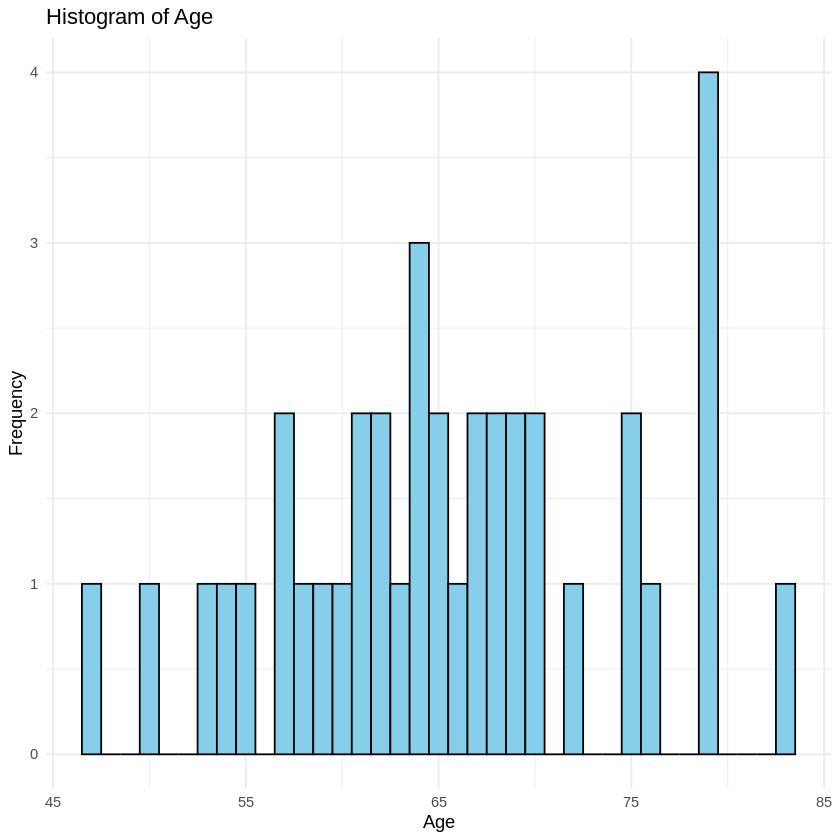

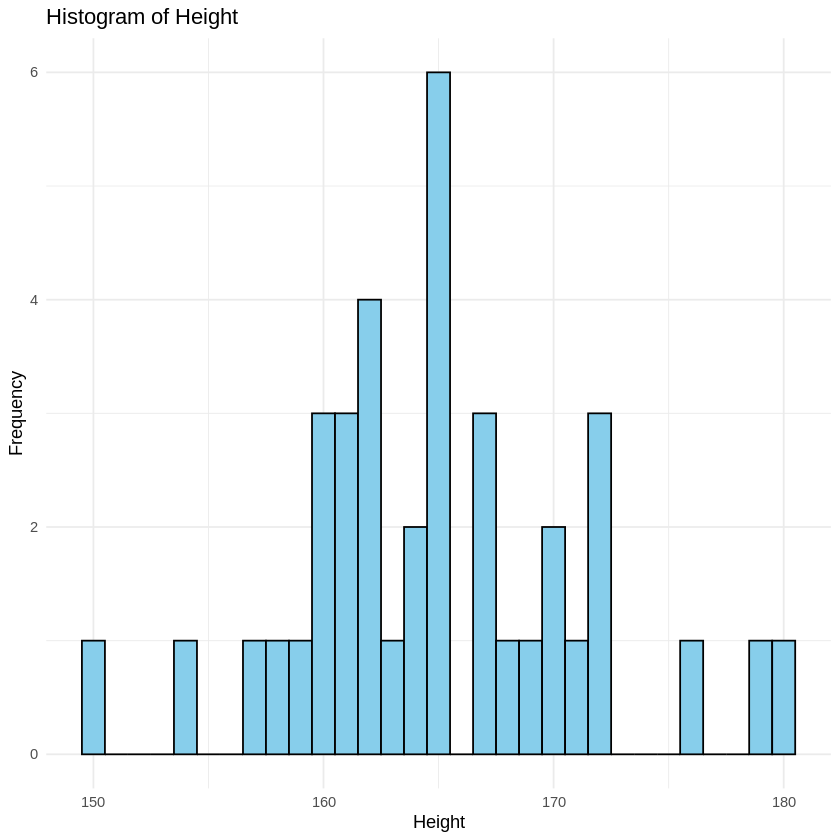

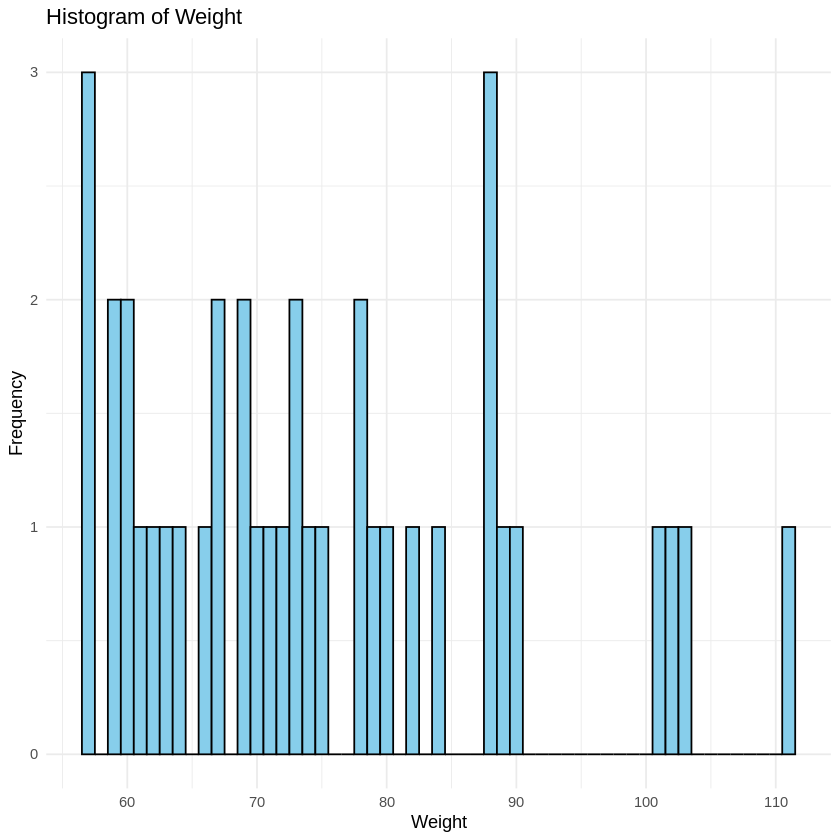

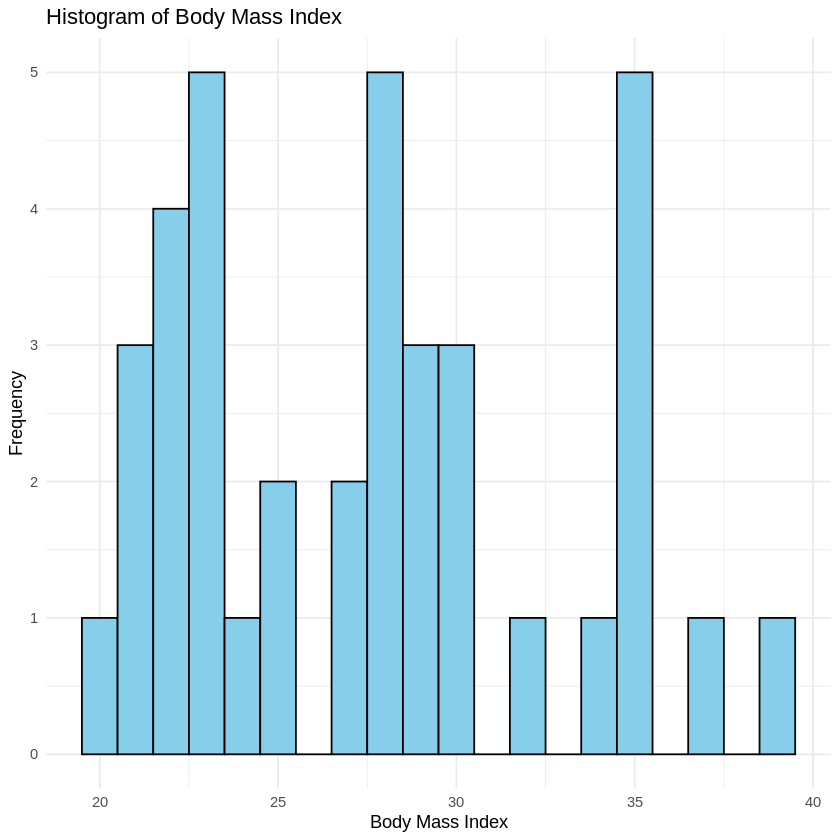

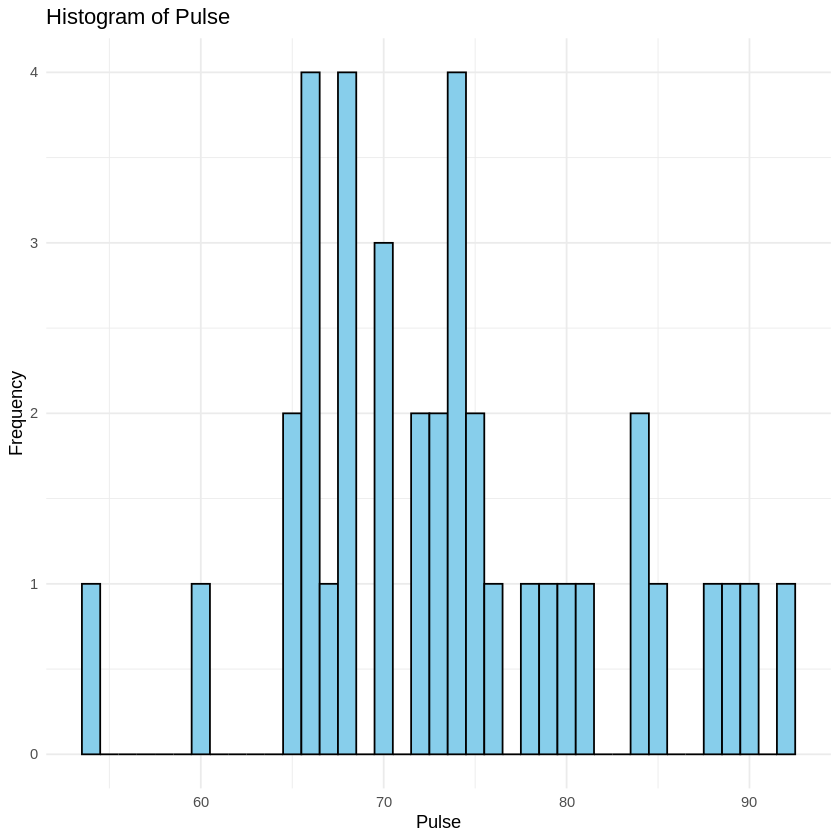

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]


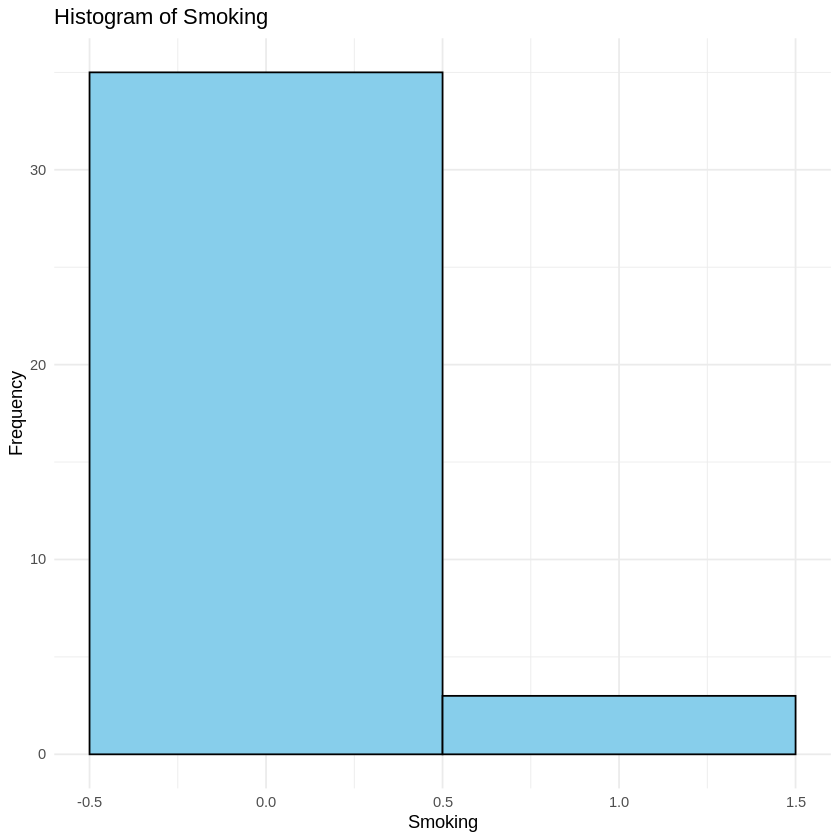

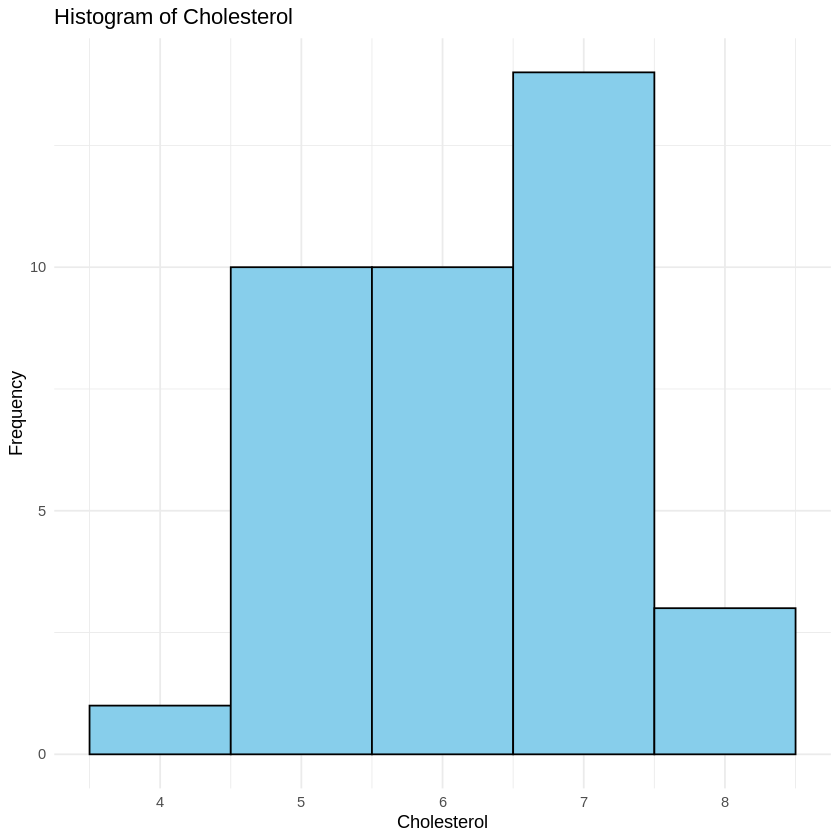

In [32]:
library(ggplot2)

# Функция для построения гистограммы с использованием ggplot2
histogram_plot_ggplot <- function(data, variable, label) {
  ggplot(data, aes(x = !!sym(variable))) +
    geom_histogram(binwidth = 1, fill = "skyblue", color = "black") +
    labs(title = paste("Histogram of", label),
         x = label, y = "Frequency") +
    theme_minimal()
}

# Список выбранных переменных и их названий
selected_variables <- c("Age", "Ht", "Wt", "BMI", "PR", "Sm", "Choi...29")
selected_labels <- c("Age", "Height", "Weight", "Body Mass Index", "Pulse", "Smoking", "Cholesterol")

# Построение гистограмм с использованием ggplot2 для выбранных переменных
hist_plots_ggplot <- mapply(histogram_plot_ggplot,
                             data = list(meta),
                             variable = selected_variables,
                             label = selected_labels,
                             SIMPLIFY = FALSE)

# Показать гистограммы
hist_plots_ggplot


Smoking:  Имеет распределение Бернули.

In [33]:
# Проверка нормальности распределения переменной Age
shapiro.test(meta$Age)
shapiro.test(meta$Ht)
shapiro.test(meta$Wt)
shapiro.test(meta$BMI)
shapiro.test(meta$PR)
shapiro.test(meta$Choi...25)


	Shapiro-Wilk normality test

data:  meta$Age
W = 0.9835, p-value = 0.8362



	Shapiro-Wilk normality test

data:  meta$Ht
W = 0.9761, p-value = 0.5801



	Shapiro-Wilk normality test

data:  meta$Wt
W = 0.93095, p-value = 0.02149



	Shapiro-Wilk normality test

data:  meta$BMI
W = 0.93281, p-value = 0.02462



	Shapiro-Wilk normality test

data:  meta$PR
W = 0.96442, p-value = 0.2634



	Shapiro-Wilk normality test

data:  meta$Choi...25
W = 0.96942, p-value = 0.3763


Результаты теста Шапиро-Уилка для каждой из переменных:

Age: p-значение = 0.8362. Имеет нормальное распределение.

Ht: p-значение = 0.5801. Имеет нормальное распределение.

Wt: p-значение = 0.02149. Имеет ненормальное распределение, визуально похоже на бимодальное.

BMI: p-значение = 0.02462. Нулевая гипотеза о нормальности распределения отвергается на уровне значимости 0.05. Имеет ненормальное распределение.

PR: p-значение = 0.2634. Имеет нормальное распределение.

Choi...25: p-значение = 0.3763. Имеет нормальное распределение.

При интерпретации результатов следует обратить внимание на значение p-значения и уровень значимости. Если p-значение меньше выбранного уровня значимости (обычно 0.05), тогда нулевая гипотеза отвергается, и данные не считаются нормально распределенными.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


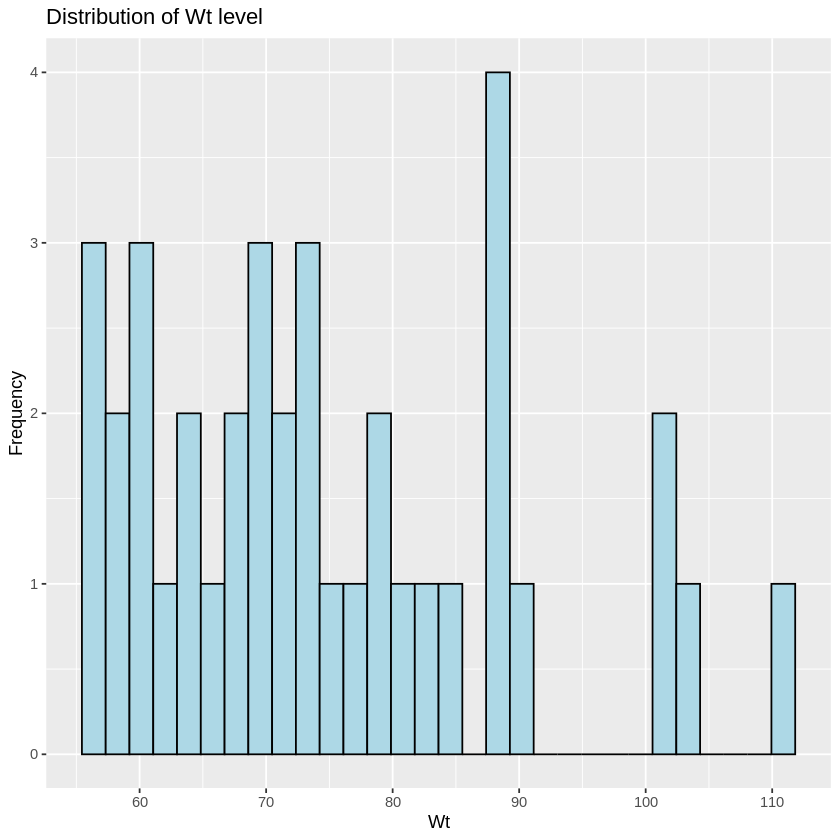

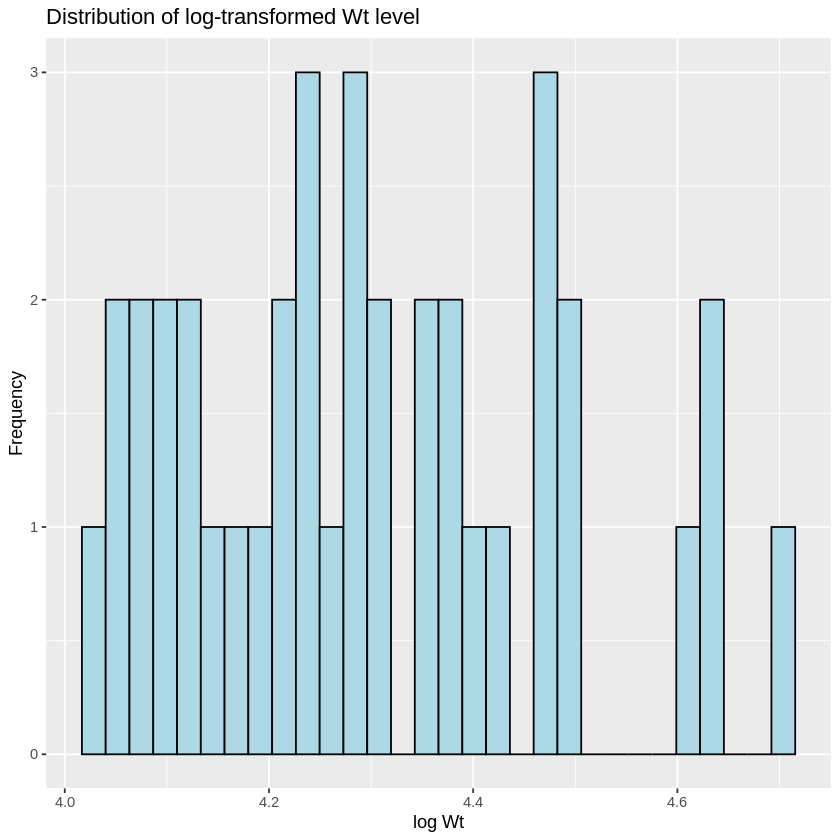

In [34]:

# Построение гистограммы для переменной Wt
ggplot(as.data.frame(meta), aes(x = Wt)) +
  geom_histogram(color = 'black', fill = "lightblue") +
  ggtitle("Distribution of Wt level") +
  scale_x_continuous(name = "Wt") +
  scale_y_continuous(name = "Frequency")

# Построение гистограммы для логарифмически преобразованной переменной Wt_log
ggplot(as.data.frame(meta), aes(x = log(Wt))) +
  geom_histogram(color = 'black', fill = "lightblue") +
  ggtitle("Distribution of log-transformed Wt level") +
  scale_x_continuous(name = "log Wt") +
  scale_y_continuous(name = "Frequency")


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


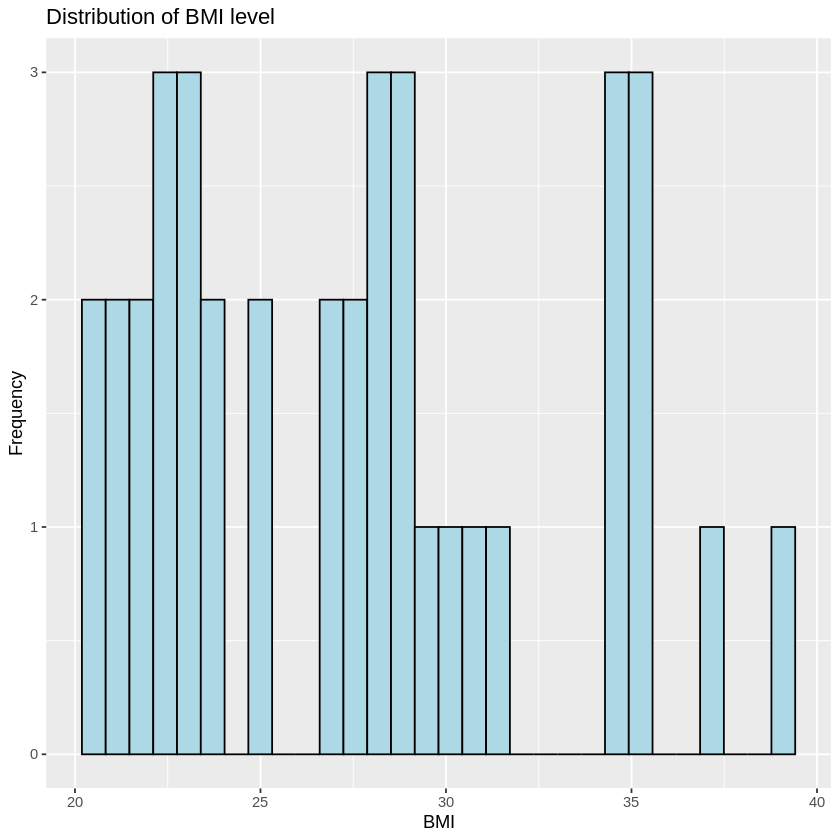

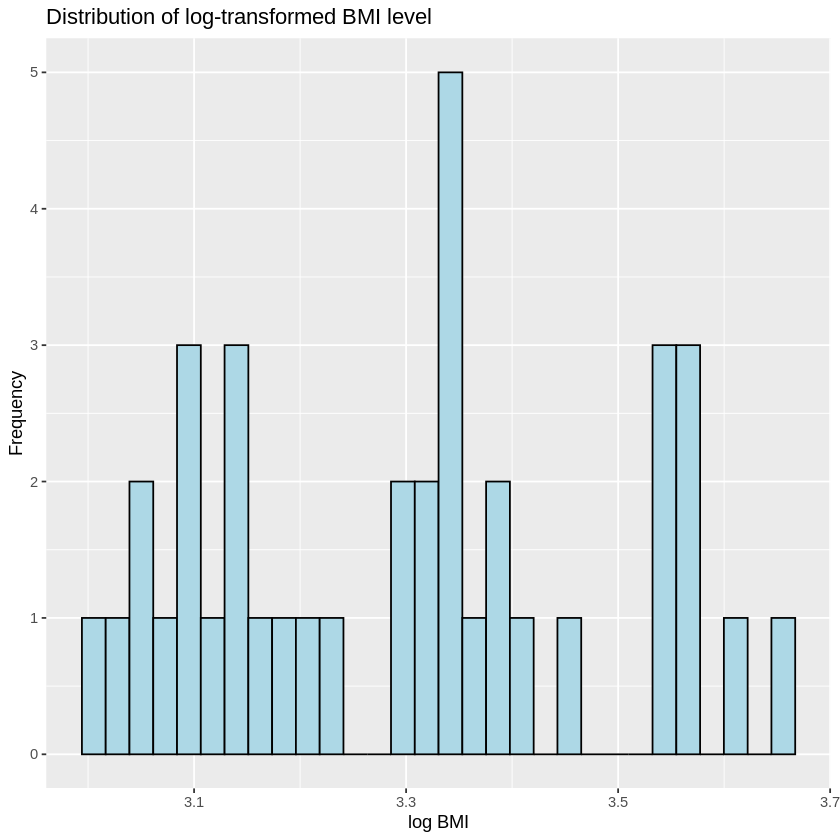

In [35]:
# Построение гистограммы для переменной BMI
ggplot(as.data.frame(meta), aes(x = BMI)) +
  geom_histogram(color = 'black', fill = "lightblue") +
  ggtitle("Distribution of BMI level") +
  scale_x_continuous(name = "BMI") +
  scale_y_continuous(name = "Frequency")

# Построение гистограммы для логарифмически преобразованной переменной BMI_log
ggplot(as.data.frame(meta), aes(x = log(BMI))) +
  geom_histogram(color = 'black', fill = "lightblue") +
  ggtitle("Distribution of log-transformed BMI level") +
  scale_x_continuous(name = "log BMI") +
  scale_y_continuous(name = "Frequency")

### Cформулируем несколько гипотез на основе данных:

### Гипотеза 1: Средний возраст пациентов с диабетом отличается от среднего возраста пациентов без диабета.
- Группы: пациенты с диабетом и пациенты без диабета.
- Зависимость: независимые выборки.
- Переменная: возраст (Age).
- Тест: двухвыборочный t-тест.

### Гипотеза 2: Средний индекс массы тела (BMI) у курящих и некурящих пациентов различается.
- Группы: курящие и некурящие пациенты.
- Зависимость: независимые выборки.
- Переменная: индекс массы тела (BMI).
- Тест: двухвыборочный t-тест.

### Гипотеза 3: Присутствует ли связь между уровнем холестерина (Choi...25) и наличием инфаркта миокарда (MI) у пациентов.
- Группы: пациенты с инфарктом миокарда и без инфаркта миокарда.
- Зависимость: независимые выборки.
- Переменные: уровень холестерина и наличие инфаркта миокарда.
- Тест: двухвыборочный t-тест.

In [36]:
# Гипотеза 1: средний возраст пациентов с диабетом отличается от среднего возраста пациентов без диабета
t.test(meta$Age ~ meta$Dm)

# Гипотеза 2: средний индекс массы тела (BMI) у курящих и некурящих пациентов различается
t.test(meta$BMI ~ meta$Sm)

# Гипотеза 3: связь между уровнем холестерина и наличием инфаркта миокарда
t.test(meta$Choi...25 ~ meta$MI)



	Welch Two Sample t-test

data:  meta$Age by meta$Dm
t = 1.0045, df = 3.9032, p-value = 0.3733
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -7.66496 16.22378
sample estimates:
mean in group 0 mean in group 1 
       66.02941        61.75000 



	Welch Two Sample t-test

data:  meta$BMI by meta$Sm
t = 1.5451, df = 2.694, p-value = 0.23
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -4.422713 11.802707
sample estimates:
mean in group 0 mean in group 1 
       27.83793        24.14793 



	Welch Two Sample t-test

data:  meta$Choi...25 by meta$MI
t = -0.3302, df = 3.3571, p-value = 0.7608
alternative hypothesis: true difference in means between group 0 and group 1 is not equal to 0
95 percent confidence interval:
 -97.42093  78.09740
sample estimates:
mean in group 0 mean in group 1 
       239.5882        249.2500 


#Выводы:

##Возраст (Age) и наличие диабета (Dm):
Нет статистически значимой разницы в среднем возрасте между группами пациентов с диабетом (группа 1) и без него (группа 0) (t(3.9032) = 1.0045, p = 0.3733, 95% ДИ [-7.66496, 16.22378]). Следовательно, наличие диабета не оказывает значимого влияния на средний возраст пациентов.
##Индекс массы тела (BMI) и курение (Sm):
Средний BMI в группе курильщиков (группа 1) ниже, чем у некурящих (группа 0), однако разница не является статистически значимой (t(2.694) = 1.5451, p = 0.23, 95% ДИ [-4.422713, 11.802707]). Это означает, что наличие курения не связано с значимым изменением среднего значения BMI.
##Уровень холестерина (Choi...25) и наличие инфаркта миокарда (MI):
Нет статистически значимой разницы в среднем уровне холестерина между группами пациентов с и без инфаркта миокарда (t(3.3571) = -0.3302, p = 0.7608, 95% ДИ [-97.42093, 78.09740]). Это означает, что наличие инфаркта миокарда не связано с изменением среднего уровня холестерина.

In [37]:
unique(meta$Group)
unique(meta$Plaque)


[1] 0 1
Levels: 0 1

[1] 1 3 2 0
Levels: 0 1 2 3

     Plaque
Group  0  1  2  3
    0  3 11  0  0
    1  0  4 17  3

Warning message in chisq.test(ctable_meta):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  ctable_meta
X-squared = 25.394, df = 3, p-value = 1.277e-05



	Fisher's Exact Test for Count Data

data:  ctable_meta
p-value = 7.017e-07
alternative hypothesis: two.sided


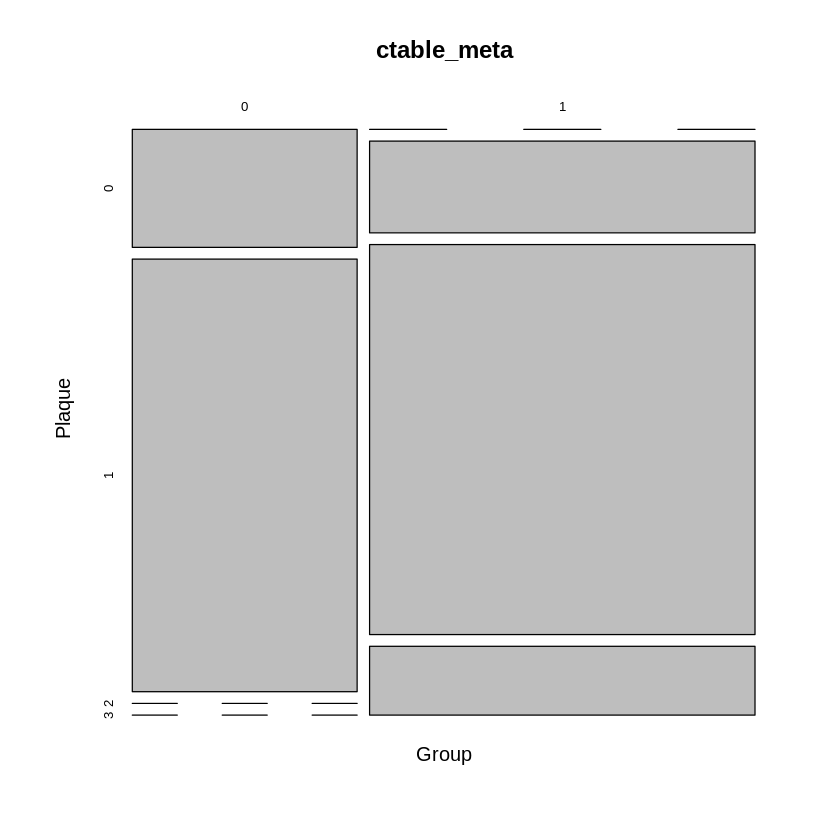

In [38]:
# Создание трехмерной таблицы
ctable_meta <- meta %>%
  filter(!is.na(Group) & !is.na(Plaque)) %>%
  xtabs(~ Group + Plaque, data = .)

# Вывод трехмерной таблицы
ctable_meta

# Визуализация трехмерной таблицы
mosaicplot(ctable_meta)

# Тест хи-квадрат
chisq.test(ctable_meta)

# Тест Фишера
fisher.test(ctable_meta)


Результаты тестов на независимость переменных "Group" и "Plaque" показывают, что существует статистически значимая связь между этими переменными.

Примечание: В медико-биологических исследованиях в качестве критического порога значимости традиционно выбирается уровень 0,05, что допускает наличие ошибки первого рода 5 раз в 100 сравнениях. При р≤ α различия принимаются статистически значимыми.

- Тест хи-квадрат дал значимое значение p < 0.05 (p = 1.277e-05), что указывает на то, что мы отвергаем нулевую гипотезу о независимости переменных.
- Тест Фишера также дал значимое значение p < 0.05 (p = 7.017e-07), подтверждая статистическую значимость связи между переменными.

Эти результаты говорят о том, что наличие или отсутствие атеросклеротического налета (Plaque) может зависеть от группы риска (Group).

In [39]:
install.packages("GGally")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘labelled’, ‘broom.helpers’, ‘patchwork’, ‘Rcpp’, ‘ggstats’, ‘plyr’




In [40]:
library(GGally)
library(dplyr)

pdf("pair_plot_meta.pdf", height = 12, width = 12)

# Отфильтруем строки с NA значениями в нужных столбцах
filtered_data <- meta %>%
  drop_na(Age, BMI, Choi...25, Sm, Sys, Dia, MI, Str)

# Выберем нужные столбцы
selected_data <- filtered_data %>%
  dplyr::select(Age, BMI, Choi...25, Sm, Sys, Dia, MI, Str)

# Создадим матрицу точечных диаграмм и сохраняем в PDF
ggpairs(selected_data,
        upper = list(continuous = wrap("cor", size = 3)),
        lower = list(continuous = wrap("smooth", alpha = 0.3, size = 0.1)))

dev.off()  # Закрываем PDF файл


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


png 
  2

In [51]:
# Проверка типа данных и длины переменной meta$Sys
class(meta$Sys)
length(meta$Sys)
table(lengths(meta$Sys))

[1] "numeric"

[1] 38


 1 
38 

In [53]:
class(meta$Sys)

[1] "list"

In [54]:
meta$Sys <- unlist(meta$Sys)

In [55]:
class(meta$Sys)

[1] "numeric"

In [56]:
install.packages("fitdistrplus")


# Загрузка пакета fitdistrplus
library(fitdistrplus)

# Создание списка возможных распределений
possible_distributions <- c("norm", "lnorm", "exp", "gamma", "weibull", "logis", "pois")

# Итеративный анализ каждого распределения
fits <- lapply(possible_distributions, function(dist) fitdist(meta$Sys, dist))

# Сводная таблица результатов
results_summary <- lapply(fits, summary)
results_summary

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[[1]]
Fitting of the distribution ' norm ' by maximum likelihood 
Parameters : 
      estimate Std. Error
mean 131.73684   2.565131
sd    15.81253   1.813821
Loglikelihood:  -158.8302   AIC:  321.6603   BIC:  324.9355 
Correlation matrix:
     mean sd
mean    1  0
sd      0  1


[[2]]
Fitting of the distribution ' lnorm ' by maximum likelihood 
Parameters : 
         estimate Std. Error
meanlog 4.8739290 0.01886955
sdlog   0.1163197 0.01333835
Loglikelihood:  -157.3753   AIC:  318.7505   BIC:  322.0257 
Correlation matrix:
              meanlog         sdlog
meanlog  1.000000e+00 -1.788355e-12
sdlog   -1.788355e-12  1.000000e+00


[[3]]
Fitting of the distribution ' exp ' by maximum likelihood 
Parameters : 
        estimate  Std. Error
rate 0.007590891 0.001209585
Loglikelihood:  -223.4706   AIC:  448.9413   BIC:  450.5789 

[[4]]
Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
        estimate Std. Error
shape 72.8704139 16.6743128
rate   0.5531571  0.12700

Из представленных результатов можно заключить, что нормальное, логнормальное, гамма- и вейбулловское распределения лучше всего соответствуют данным, в то время как экспоненциальное распределение, распределение Пуассона и логистическое распределение демонстрируют более слабое соответствие.

In [59]:
# Построим модель дисперсионного анализа с двумя зависимыми переменными Sys и Dia
# ANOVA с двумя зависимыми переменными и двумя факторами:
model <- aov(cbind(Sys, Dia) ~ Group * HT, data = meta)

# Проведение ANOVA анализа
summary(model)


 Response Sys :
            Df Sum Sq Mean Sq F value Pr(>F)
Group        1  658.7  658.68  2.6909 0.1101
HT           1  385.2  385.22  1.5737 0.2182
Group:HT     1  134.9  134.94  0.5513 0.4629
Residuals   34 8322.5  244.78               

 Response Dia :
            Df Sum Sq Mean Sq F value Pr(>F)
Group        1  210.1 210.138  1.8267 0.1854
HT           1    7.2   7.245  0.0630 0.8034
Group:HT     1  212.1 212.076  1.8435 0.1835
Residuals   34 3911.3 115.038               


Ни один из этих факторов не оказывает статистически значимого влияния на переменные Sys и Dia, так как все значения p-value выше уровня значимости 0.05.

In [60]:
# Проведение MANOVA анализа
model <- manova(cbind(Dia, Sys) ~ Group * HT, data = meta)

# Вывод результатов MANOVA анализа
summary(model)


          Df   Pillai approx F num Df den Df Pr(>F)
Group      1 0.084007  1.51323      2     33 0.2351
HT         1 0.068270  1.20899      2     33 0.3114
Group:HT   1 0.051777  0.90097      2     33 0.4159
Residuals 34                                       

Эти результаты указывают на отсутствие статистически значимых различий между группами и временем гипертензии в отношении переменных Sys и Dia.

## Итак, мы проверили несколько гипотез:

1. **Гипотеза о влиянии группы на переменные Sys и Dia:**
   - **Гипотеза:** Существует статистически значимое различие между группами в отношении переменных Sys и Dia.
   - **Результат:** Результаты ANOVA и MANOVA показывают, что влияние группы на переменные Sys и Dia не является статистически значимым (p > 0.05). Это означает, что нет достаточных доказательств для того, чтобы отвергнуть нулевую гипотезу о том, что средние значения Sys и Dia не различаются между группами.

2. **Гипотеза о влиянии времени гипертензии на переменные Sys и Dia:**
   - **Гипотеза:** Существует статистически значимое различие в переменных Sys и Dia в зависимости от времени гипертензии.
   - **Результат:** Результаты ANOVA и MANOVA также не показывают статистически значимого влияния времени гипертензии на переменные Sys и Dia (p > 0.05). Таким образом, нет достаточных доказательств для того, чтобы отвергнуть нулевую гипотезу о том, что средние значения Sys и Dia не различаются в зависимости от времени гипертензии.

3. **Гипотеза о взаимодействии группы и времени гипертензии на переменные Sys и Dia:**
   - **Гипотеза:** Существует статистически значимое взаимодействие между группой и временем гипертензии в отношении переменных Sys и Dia.
   - **Результат:** Результаты ANOVA и MANOVA не подтверждают статистически значимого взаимодействия между группой и временем гипертензии в отношении переменных Sys и Dia (p > 0.05). Таким образом, нет достаточных доказательств для того, чтобы отвергнуть нулевую гипотезу о том, что влияние группы и времени гипертензии на переменные Sys и Dia не зависит друг от друга.

Таким образом, на основании результатов ANOVA и MANOVA, мы не можем отвергнуть нулевые гипотезы о том, что средние значения переменных Sys и Dia не различаются между группами, в разные периоды времени гипертензии, а также в их взаимодействии.

## Проверим еще несколько гипотез

4. **Гипотеза 4: Средний возраст пациентов с диабетом отличается от среднего возраста пациентов без диабета.**

In [65]:

# Проведение ANOVA
model_age <- aov(Age ~ Group, data = meta)

# Вывод результатов
summary(model_age)

            Df Sum Sq Mean Sq F value Pr(>F)  
Group        1    220   220.0    3.09 0.0873 .
Residuals   36   2563    71.2                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Значение p больше уровня значимости 0.05, что означает, что нет статистически значимых различий в среднем возрасте между группами пациентов с диабетом и без диабета на уровне значимости 0.05. Однако, p-value равно 0.0873, что меньше 0.1, поэтому мы можем наблюдать тенденцию к различию между группами.

Таким образом, на основании результатов ANOVA нет достаточных доказательств для того, чтобы отвергнуть нулевую гипотезу о том, что средний возраст пациентов с диабетом не отличается от среднего возраста пациентов без диабета на уровне значимости 0.05. Однако, результаты могут быть интерпретированы с осторожностью, так как значение p находится близко к уровню значимости 0.05.

5. **Гипотеза 5: Средний индекс массы тела (BMI) у курящих и некурящих пациентов различается.**

In [68]:
# Проведение ANOVA
model_bmi <- aov(BMI ~ Sm, data = meta)

# Вывод результатов
summary(model_bmi)

            Df Sum Sq Mean Sq F value Pr(>F)
Sm           1   37.6   37.62   1.392  0.246
Residuals   36  973.1   27.03               

Значение p больше уровня значимости 0.05, что означает, что нет статистически значимых различий в среднем индексе массы тела между курящими и некурящими пациентами на уровне значимости 0.05.

Таким образом, на основании результатов ANOVA нет достаточных доказательств для того, чтобы отвергнуть нулевую гипотезу о том, что средний индекс массы тела не отличается у курящих и некурящих пациентов на уровне значимости 0.05.

6. **Гипотеза 6: Присутствует ли связь между уровнем холестерина и наличием инфаркта миокарда у пациентов..**

In [69]:
# Проведение ANOVA
model_cholesterol <- aov(Choi...25 ~ MI, data = meta)

# Вывод результатов
summary(model_cholesterol)

            Df Sum Sq Mean Sq F value Pr(>F)
MI           1    334   334.1   0.193  0.663
Residuals   36  62377  1732.7               

Значение p больше уровня значимости 0.05, что означает, что нет статистически значимых различий в уровне холестерина между пациентами с инфарктом миокарда и пациентами без инфаркта миокарда на уровне значимости 0.05.

Таким образом, на основании результатов ANOVA нет достаточных доказательств для того, чтобы отвергнуть нулевую гипотезу о том, что уровень холестерина не различается у пациентов с инфарктом миокарда и пациентов без инфаркта миокарда на уровне значимости 0.05.
